In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
# local imports
import sys
sys.path.insert(1, '../')
from utilities import utilities
#from ..utilities import utilities

In [2]:
# configure tqdm printing
#%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [3]:
path = '../physiobank_tool/challenge'
number_of_segments = 120
low_cut = 0.1 # specific for this dataset

In [4]:
files = []

with open(path+'/novo_header.txt') as f:
    reader = csv.reader(f)
    for row in reader:
        #print(row)
        files.append(row[0])
print("Read data for the following drivers:\n", files[:10])

Read data for the following drivers:
 ['te03-0024', 'te03-0031', 'te03-0032', 'te03-0037', 'te03-0041', 'te03-0046', 'te03-0050', 'te03-0054', 'te03-0062', 'te03-0076']


In [5]:
def read_file(file_name):
    ''' Read ecg information from a file and saves it to a dataframe  '''
    cols_of_interest = [0,1]
    ecg_data = pd.read_csv(f'{path}/{file_name}.csv', usecols=cols_of_interest)
    # drop useless header
    ecg_data = ecg_data.drop(ecg_data.index[0])
    # name columns
    ecg_data.columns = ['time', 'ECG']
    # cast some columns to float
    ecg_data['time'] = ecg_data['time'].astype(float)
    ecg_data['ECG'] = ecg_data['ECG'].astype(float)
    
    return ecg_data

In [6]:
def run(ecg_data, file_name, number_of_segments, low_cut):
    """Execute the pipeline that segmentate and extract the features of a ecg signal 
    inputted as a dataframe"""
    sample_rate = utilities.detect_sample_rate(ecg_data)
    high_cut = sample_rate/3.0
    
    data_preparation_pipeline = Pipeline([
        ('filtering', utilities.Filter(sample_rate, low_cut, high_cut)),
        ('feature_detection', utilities.FeatureExtractor(number_of_segments, sample_rate)),
        ])

    extracted_features_df = data_preparation_pipeline.fit_transform(ecg_data['ECG'])
    extracted_features_df.reset_index(drop=True, inplace=True)
    return extracted_features_df

In [7]:
# A final dataframe to store all subjects (people) ecg information 
features_df = pd.DataFrame()
# read every file and return the dataframe of extracted features for ech file
for file in tqdm(files):
    ecg_data = read_file(file)
    current_df = run(ecg_data, file, number_of_segments, low_cut)
    current_df['person'] = file
    features_df = pd.concat([current_df, features_df], ignore_index=True)

    

/home/renato/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/renato/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
# Check an example
features_df.head(5)

,mean_q,mean_r,mean_s,stdev_q,stdev_r,stdev_s,mean_qrs_interval,mean_rr_interval,mean_rq_amplitude,person
0,-1.039036,0.409978,0.154258,0.022635,0.010087,0.019942,930.000000,1.449014,50.000000,tr14-0291
1,-0.631026,0.342097,0.162954,0.489841,0.070941,0.013946,430.000000,0.973123,61.666667,tr14-0291
2,-0.760507,0.372729,0.161926,0.512700,0.062801,0.024830,566.666667,1.133236,62.500000,tr14-0291
3,-1.079679,0.436452,0.169464,0.034610,0.020878,0.008969,920.000000,1.516131,52.500000,tr14-0291
4,-1.071868,0.458018,0.168823,0.008050,0.019041,0.001151,870.000000,1.529886,50.000000,tr14-0291


In [9]:
# check if we have equivalent number of examples per class   
#features_df['person'].value_counts()

In [10]:
# Save the final extracted features
now = str(datetime.now())
features_df.to_csv(f"../extracted_features_files/challange.csv", index=False)

In [11]:
## Examples below

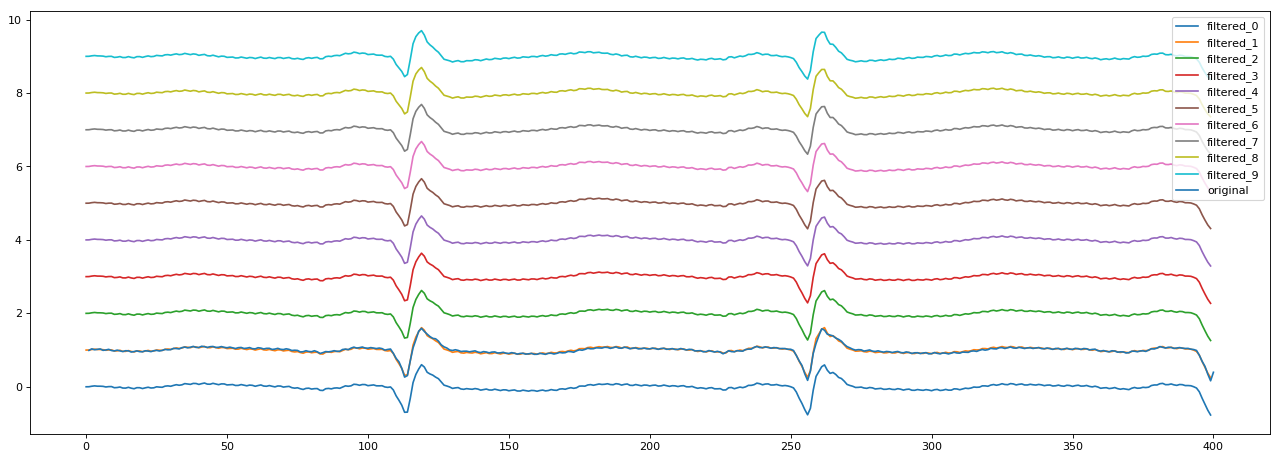

In [12]:
ecg_data = read_file(files[1])
sample_rate = utilities.detect_sample_rate(ecg_data)
two_seconds = ecg_data['ECG'][0:sample_rate*2]
plt.figure(figsize=(20, 7), dpi= 80, facecolor='w', edgecolor='k')

list_of_filters = [utilities.Filter(sample_rate, x, sample_rate/3.0) for x in np.linspace(0.1, 1, 10)]
list_of_filtered_signals = [x.fit_transform(two_seconds) + index for index, x in enumerate(list_of_filters)]

for index, signal in enumerate(list_of_filtered_signals):
    plt.plot(signal, label=f'filtered_{index}')
plt.plot(two_seconds+1.0, label='original')
plt.legend()